In [1]:
from math import exp,sqrt,log
import numpy as np
from matplotlib import pyplot as plt
from pynverse import inversefunc
import csv 

In [2]:
# state reward function
def f(x):
    return(2*x-1)

# PF-eigenvalue
def rho(theta, p,  q):
    return(((1-p)*exp(-theta) + q*exp(theta) + sqrt((q*exp(theta)-(1-p)*exp(-theta))**2 + 4*p*(1-q)))/2)

# log-PF-eigenvalue
def log_rho(theta, p,  q):
    return(log(rho(theta, p,  q)))

# log-PF-eigenvalue derivative
def log_rho_prime(theta, p,  q):
    return((q*exp(theta)-(1-p)*exp(-theta))/sqrt((q*exp(theta)-(1-p)*exp(-theta))**2 + 4*p*(1-q)))

# inverse-log-PF-eigenvalue derivative
def inverse_log_rho_prime(mu, p,  q):
    return(log((sqrt(p*(1-q))*mu + sqrt(p*(1-q)*mu**2 + q*(1-p)*(1-mu**2)))/(q*sqrt(1-mu**2))))
    
# theta transition probability matrix
def theta_transitions(theta, p,  q):
    r = rho(theta, p,  q)
    p_theta = 1 - (1-p)*exp(-theta)/r
    q_theta = q*exp(theta)/r
    return(p_theta, q_theta)

# KL-divergence rate
def KL(theta1, theta2, p, q):
    return(log_rho(theta2, p, q) - log_rho(theta1, p, q) - log_rho_prime(theta1, p, q)*(theta2 - theta1))

def UCB(s, n, variance_proxy, t, p, q):
    return(s/n + sqrt(4*variance_proxy*log(t)/n))

def g(t):
    return(log(t)+3*log(log(t)))

def KL_UCB(s, n, variance_proxy, t, p, q):
    avg = s/n
    if avg == 1.0: return(1.0)
    if avg == -1.0: theta1 = -20.0
    else: theta1 = inverse_log_rho_prime(avg, p,  q)
    theta2 = inversefunc(lambda theta2 : KL(theta1, theta2, p, q), y_values=g(t)/n, domain=[theta1, 20])
    return(log_rho_prime(theta2, p,  q))

In [3]:
# number of arms
K = 10
# number of plays
M = 3
# time horizon
T = 10**4
# generator transition probabilities
p = 0.49
q = 0.45

# theta1, ..., thetaK i.i.d. Guassians, descending order
thetas = np.random.normal(0, 1/2, K)
thetas.sort()
print(thetas)

# mu1, ..., muK
mus = np.zeros(K)
for a in range(K): mus[a] = log_rho_prime(thetas[a], p, q)
print(mus)

# P1, ..., PK
transitions = np.zeros((K,2))
for a in range(K): 
    p_theta, q_theta = theta_transitions(thetas[a], p,  q)
    transitions[a,0] = p_theta
    transitions[a,1] = q_theta
print(transitions)

# variance proxy for UCB
variance_proxy = 1
#max([1/min(transitions[a][0]**2, (1-transitions[a][1])**2) for a in range(K)])

# best one time reward
best_reward = 0
for a in range(K-M,K): best_reward += mus[a]
print(best_reward)
    
# optimal constant
optimal_constant = 0
for b in range(0,K-M): optimal_constant += (mus[K-M] - mus[b])/KL(thetas[b], thetas[K-M], p, q)
print(optimal_constant)

[-0.68281207 -0.50568881 -0.48874249 -0.17545481 -0.08324363  0.03935635
  0.07911951  0.41975352  0.55380751  0.64728201]
[-0.60170909 -0.48399265 -0.47168775 -0.21648409 -0.13383143 -0.02142945
  0.01526028  0.3190591   0.42666434  0.49575413]
[[0.20409685 0.17923364]
 [0.26578329 0.23563016]
 [0.27225131 0.24160585]
 [0.40668946 0.36857536]
 [0.45013342 0.41076664]
 [0.50891774 0.46879296]
 [0.52800368 0.48786906]
 [0.68311058 0.64735627]
 [0.73640572 0.70405957]
 [0.77006779 0.74039617]]
1.241477571129324
24.579319260967505


In [4]:
def index_algorithm(K, M, T, transitions, variance_proxy, p, q, best_reward, index_calculator):
    # initial states for the K chains
    states = np.zeros(K, dtype=int)
    times_pulled = np.zeros(K)
    sums = np.zeros(K)
    indices = np.zeros(K)
    regrets = np.zeros(T)

    # initialization
    regrets[K-1] = 0
    for a in range(K):
        for _ in range(M):
            states[a] = int(np.random.random_sample() < transitions[a,states[a]])
            times_pulled[a] += 1
            sums[a] += f(states[a])
        regrets[K-1] += best_reward - sums[a]

    for t in range(K,T):
        for a in range(K):
            indices[a] = index_calculator(sums[a], times_pulled[a], variance_proxy, t, p, q)
        topM = np.argsort(np.array(indices))[K-M:K]
        current_reward = 0
        for a in topM:
            states[a] = int(np.random.random_sample() < transitions[a][states[a]])
            times_pulled[a] += 1
            reward = f(states[a])
            sums[a] += reward
            current_reward += reward
        regrets[t] = regrets[t-1] + best_reward - current_reward
    
    return(regrets)

In [5]:
regrets = np.zeros(T)
MC_iterations = 10**2
for _ in range(MC_iterations):
    regrets += index_algorithm(K, M, T, transitions, variance_proxy, p, q, best_reward, UCB)/MC_iterations

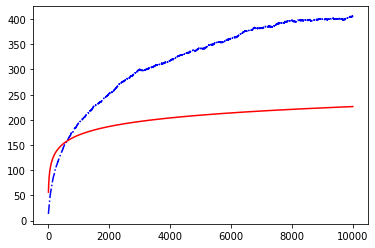

In [6]:
plt.plot(range(K,T), regrets[K:T], 'b-.')
lower_bound = [optimal_constant*log(t) for t in range(K, T)]
plt.plot(range(K,T), lower_bound, 'r-')
plt.savefig('UCB.png')
# plt.show()

In [ ]:
np.savetxt("UCB.csv", regrets, delimiter=",")